<a href="https://colab.research.google.com/github/1273474/e-commerce-delivery-prediction/blob/main/delivery_delay_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 1. Install the Kaggle library
!pip install kaggle

# 2. Import the 'files' module from google.colab
from google.colab import files

# 3. Prompt you to upload your kaggle.json file
print("Please upload your 'kaggle (1).json' API token file:")
files.upload()

print("\n'kaggle (1).json' uploaded successfully.")

Please upload your 'kaggle (1).json' API token file:


Saving kaggle (1).json to kaggle (1) (1).json

'kaggle (1).json' uploaded successfully.


In [5]:
# 1. Create the .kaggle directory
!mkdir -p ~/.kaggle

# 2. Move your uploaded file and RENAME it to what the API expects
!cp 'kaggle (1).json' ~/.kaggle/kaggle.json

# 3. Set the required file permissions
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured.")

Kaggle API configured.


In [6]:
# 1. Download the dataset from Kaggle
# The dataset's path on Kaggle is 'olistbr/brazilian-ecommerce'
print("Downloading Olist dataset from Kaggle...")
!kaggle datasets download -d olistbr/brazilian-ecommerce

# 2. Unzip the downloaded file into a specific directory
print("\nUnzipping dataset...")
!mkdir -p ./olist-dataset
!unzip brazilian-ecommerce.zip -d ./olist-dataset

print("\nFiles unzipped successfully into '/content/olist-dataset/'.")
# List the files to confirm
!ls ./olist-dataset

Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
  0% 0.00/42.6M [00:00<?, ?B/s]
100% 42.6M/42.6M [00:00<00:00, 2.53GB/s]

Unzipping dataset...
Archive:  brazilian-ecommerce.zip
  inflating: ./olist-dataset/olist_customers_dataset.csv  
  inflating: ./olist-dataset/olist_geolocation_dataset.csv  
  inflating: ./olist-dataset/olist_order_items_dataset.csv  
  inflating: ./olist-dataset/olist_order_payments_dataset.csv  
  inflating: ./olist-dataset/olist_order_reviews_dataset.csv  
  inflating: ./olist-dataset/olist_orders_dataset.csv  
  inflating: ./olist-dataset/olist_products_dataset.csv  
  inflating: ./olist-dataset/olist_sellers_dataset.csv  
  inflating: ./olist-dataset/product_category_name_translation.csv  

Files unzipped successfully into '/content/olist-dataset/'.
olist_customers_dataset.csv	  olist_orders_dataset.csv
olist_geolocation_dataset.csv	  olist_products_dataset.csv
olist_order_items_dataset.csv	  olist_sellers_d

In [7]:
# 1. Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported.")

# 2. Set the correct data path (now local to our Colab environment)
DATA_PATH = './olist-dataset/'

# 3. Load all Olist data files
try:
    customers = pd.read_csv(DATA_PATH + 'olist_customers_dataset.csv')
    geolocation = pd.read_csv(DATA_PATH + 'olist_geolocation_dataset.csv')
    order_items = pd.read_csv(DATA_PATH + 'olist_order_items_dataset.csv')
    order_payments = pd.read_csv(DATA_PATH + 'olist_order_payments_dataset.csv')
    order_reviews = pd.read_csv(DATA_PATH + 'olist_order_reviews_dataset.csv')
    orders = pd.read_csv(DATA_PATH + 'olist_orders_dataset.csv')
    products = pd.read_csv(DATA_PATH + 'olist_products_dataset.csv')
    sellers = pd.read_csv(DATA_PATH + 'olist_sellers_dataset.csv')
    category_translation = pd.read_csv(DATA_PATH + 'product_category_name_translation.csv')

    print("All Olist data files loaded successfully.")

    # Verify the main 'orders' table
    print("\nSample of 'orders' table:")
    display(orders.head())

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Loading failed. Please ensure the files were unzipped correctly into the 'olist-dataset' directory.")

Libraries imported.
All Olist data files loaded successfully.

Sample of 'orders' table:


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [8]:
# Start with a copy of the orders dataframe to avoid modifying the original
df_orders = orders.copy()

# 1. Filter for 'delivered' orders only
df_orders = df_orders[df_orders['order_status'] == 'delivered']

# 2. Convert timestamp columns to datetime objects
date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in date_columns:
    df_orders[col] = pd.to_datetime(df_orders[col], errors='coerce')

# 3. Drop rows with missing critical dates
df_orders = df_orders.dropna(subset=['order_delivered_customer_date', 'order_estimated_delivery_date'])

print(f"Original orders: {len(orders)}, Delivered & Cleaned orders: {len(df_orders)}")
print("Timestamp columns converted and nulls dropped.")

Original orders: 99441, Delivered & Cleaned orders: 96470
Timestamp columns converted and nulls dropped.


In [9]:
# 1. Calculate the delivery delay in days
df_orders['delivery_delay_days'] = (
    df_orders['order_delivered_customer_date'] - df_orders['order_estimated_delivery_date']
).dt.days

# 2. Create the binary 'delayed_flag'
df_orders['delayed_flag'] = (df_orders['delivery_delay_days'] > 0).astype(int)

print("Target variables 'delivery_delay_days' and 'delayed_flag' created.")

# 3. Let's verify our new columns
print("\n--- Verification of New Columns ---")
print(df_orders[['order_estimated_delivery_date', 'order_delivered_customer_date', 'delivery_delay_days', 'delayed_flag']].sample(5))

print("\n--- Distribution of 'delivery_delay_days' (Regression Target) ---")
print(df_orders['delivery_delay_days'].describe())

print("\n--- Distribution of 'delayed_flag' (Classification Target) ---")
print(df_orders['delayed_flag'].value_counts(normalize=True))

Target variables 'delivery_delay_days' and 'delayed_flag' created.

--- Verification of New Columns ---
      order_estimated_delivery_date order_delivered_customer_date  \
37312                    2017-11-06           2017-10-26 22:23:46   
91220                    2018-07-03           2018-06-08 22:38:24   
86876                    2018-04-23           2018-04-17 19:47:27   
64008                    2017-12-13           2017-11-29 21:37:56   
81740                    2018-08-03           2018-08-04 17:50:39   

       delivery_delay_days  delayed_flag  
37312                  -11             0  
91220                  -25             0  
86876                   -6             0  
64008                  -14             0  
81740                    1             1  

--- Distribution of 'delivery_delay_days' (Regression Target) ---
count    96470.000000
mean       -11.875889
std         10.182105
min       -147.000000
25%        -17.000000
50%        -12.000000
75%         -7.000000
ma

In [10]:
# 1. Merge items with products to get product details (weight, category)
df_items_products = order_items.merge(products, on='product_id', how='left')

# 2. Merge with category translation to get English names
df_items_products = df_items_products.merge(category_translation, on='product_category_name', how='left')

# 3. Fill any missing English categories with 'unknown'
df_items_products['product_category_name_english'] = df_items_products['product_category_name_english'].fillna('unknown')

print(f"Merged items, products, and categories. Shape: {df_items_products.shape}")
display(df_items_products.head())

# 4. Now, aggregate this data at the 'order_id' level
# We define what to do with each column
agg_functions = {
    'order_item_id': 'count',  # To get the number of items in the order
    'price': 'sum',            # Total price of all items
    'freight_value': 'sum',    # Total freight of all items
    'product_weight_g': 'sum', # Total weight of the order
    'seller_id': 'first',      # Business decision: attribute order to the first seller
    'product_category_name_english': 'first' # Business decision: attribute order to the first item's category
}

df_order_agg = df_items_products.groupby('order_id').agg(agg_functions)

# 5. Rename columns for clarity
df_order_agg = df_order_agg.rename(columns={
    'order_item_id': 'num_items',
    'price': 'total_price',
    'freight_value': 'total_freight',
    'product_weight_g': 'total_weight_g',
    'product_category_name_english': 'primary_category'
})

print("\nAggregated order-level features created.")
display(df_order_agg.head())

Merged items, products, and categories. Shape: (112650, 16)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,garden_tools



Aggregated order-level features created.


,num_items,total_price,total_freight,total_weight_g,seller_id,primary_category
order_id,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,58.90,13.29,650.0,48436dade18ac8b2bce089ec2a041202,cool_stuff
00018f77f2f0320c557190d7a144bdd3,1,239.90,19.93,30000.0,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop
000229ec398224ef6ca0657da4fc703e,1,199.00,17.87,3050.0,5b51032eddd242adc84c38acab88f23d,furniture_decor
00024acbcdf0a6daa1e931b038114c75,1,12.99,12.79,200.0,9d7a1d34a5052409006425275ba1c2b4,perfumery
00042b26cf59d7ce69dfabb4e55b4fd9,1,199.90,18.14,3750.0,df560393f3a51e74553ab94004ba5c87,garden_tools


In [11]:
# 1. Start with our clean df_orders table from Step 1
df_master = df_orders.copy()

# 2. Merge with the aggregated order features
# We use 'left' merge to keep all orders from df_orders, even if they have no item info (though unlikely)
df_master = df_master.merge(df_order_agg, on='order_id', how='left')

# 3. Merge with the customers table to get customer location
df_master = df_master.merge(customers, on='customer_id', how='left')

# 4. Merge with the sellers table to get seller location
# This merge uses the 'seller_id' we got from the df_order_agg table
df_master = df_master.merge(sellers, on='seller_id', how='left')

print("Master feature table created.")

# 5. Let's check the result
print(f"\nShape of master table: {df_master.shape}")
print("\nColumns in master table:")
print(df_master.info())

# 6. Display a sample
print("\nSample of master table (scroll right to see all columns):")
pd.set_option('display.max_columns', None) # Show all columns
display(df_master.sample(5))

Master feature table created.

Shape of master table: (96470, 23)

Columns in master table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96470 entries, 0 to 96469
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96470 non-null  object        
 1   customer_id                    96470 non-null  object        
 2   order_status                   96470 non-null  object        
 3   order_purchase_timestamp       96470 non-null  datetime64[ns]
 4   order_approved_at              96456 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96469 non-null  datetime64[ns]
 6   order_delivered_customer_date  96470 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96470 non-null  datetime64[ns]
 8   delivery_delay_days            96470 non-null  int64         
 9   delayed_flag                   96470 non-null  int64     

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay_days,delayed_flag,num_items,total_price,total_freight,total_weight_g,seller_id,primary_category,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
62631,6087c740ddca7b0c465bda072107a1a9,27862af84c148e9a656de216a213fd12,delivered,2018-08-19 18:13:40,2018-08-20 12:51:03,2018-08-21 17:54:00,2018-08-22 23:51:41,2018-08-31,-9,0,1,12.50,7.39,280.0,c1dde11f12d05c478f5de2d7319ad3b2,computers_accessories,767bea758a58d2b420ffbf1eef7f5751,11070,santos,SP,1026,sao paulo,SP
44254,42831051f86bdc3bea417f93d5fd981e,b4e2f9032306f3f68ef7afee47fc278c,delivered,2018-03-21 21:05:39,2018-03-21 21:15:27,2018-04-05 18:56:28,2018-04-12 18:14:27,2018-04-24,-12,0,1,139.94,39.84,16617.0,7c67e1448b00f6e969d365cea6b010ab,furniture_decor,8322ac348d132588470c5e8cc56b2bb8,19800,assis,SP,8577,itaquaquecetuba,SP
81304,448e3433c1fdb3dc2678294be291a7ec,5f3f626700a3d4f153ae552760785e79,delivered,2018-06-29 09:30:46,2018-06-29 09:49:42,2018-06-29 14:58:00,2018-07-05 19:17:48,2018-07-25,-20,0,1,79.00,16.74,950.0,dfa0c4c6229ab200a4a1336b4d7128ff,luggage_accessories,1274a8553a27e023e02510965e0c2d2a,3032,sao paulo,SP,88085,florianopolis,SC
77449,4af58f695f1f0ed484c93be8b6e8b845,7bb9a8dd609778f4f40ced2ce708e67c,delivered,2018-02-02 21:42:32,2018-02-03 02:54:06,2018-02-05 19:16:57,2018-02-10 16:58:38,2018-02-20,-10,0,1,114.90,12.51,1400.0,da8622b14eb17ae2831f4ac5b9dab84a,bed_bath_table,924b585f6c30a1b3107ce437e1de47af,11704,praia grande,SP,13405,piracicaba,SP
91217,f27705c756d5861edbbc8ad2191c5dfe,9b4377673a98f0fc33e7f4b78af63878,delivered,2017-12-11 10:24:07,2017-12-13 02:36:39,2017-12-14 15:59:05,2017-12-18 19:29:10,2017-12-28,-10,0,1,122.99,9.06,400.0,c826c40d7b19f62a09e2d7c5e7295ee2,unknown,cfcadf97c3ae58050350449f27e129ff,13212,jundiai,SP,7133,guarulhos,SP


In [12]:
# 1. Aggregate the geolocation data
# A single zip code prefix can have multiple lat/lon entries. We'll take the mean.
print("Aggregating geolocation data...")
geo_agg = geolocation.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).reset_index()

display(geo_agg.head())

# 2. Merge this aggregated data with our master table TWICE.
# First, merge for the CUSTOMER location
df_master = df_master.merge(
    geo_agg,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
)
df_master = df_master.rename(columns={'geolocation_lat': 'customer_lat', 'geolocation_lng': 'customer_lng'})
df_master = df_master.drop(columns=['geolocation_zip_code_prefix']) # Drop the redundant zip column

# Second, merge for the SELLER location
df_master = df_master.merge(
    geo_agg,
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
)
df_master = df_master.rename(columns={'geolocation_lat': 'seller_lat', 'geolocation_lng': 'seller_lng'})
df_master = df_master.drop(columns=['geolocation_zip_code_prefix'])

print("Customer and seller coordinates merged into master table.")

Aggregating geolocation data...


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-23.550190,-46.634024
1,1002,-23.548146,-46.634979
2,1003,-23.548994,-46.635731
3,1004,-23.549799,-46.634757
4,1005,-23.549456,-46.636733


Customer and seller coordinates merged into master table.


In [13]:
# 3. Define the Haversine distance function
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance in kilometers between two points
    on the earth (specified in decimal degrees).
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
    return c * r

# 4. Calculate the distance for all orders
# We use .values to pass the NumPy arrays for a fast, vectorized calculation
df_master['seller_to_customer_distance_km'] = haversine_distance(
    df_master['seller_lat'].values,
    df_master['seller_lng'].values,
    df_master['customer_lat'].values,
    df_master['customer_lng'].values
)

print("Seller-to-customer distance calculated.")
display(df_master[['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng', 'seller_to_customer_distance_km']].sample(5))

Seller-to-customer distance calculated.


,customer_lat,customer_lng,seller_lat,seller_lng,seller_to_customer_distance_km
16623,-16.882339,-42.089937,-19.869495,-43.950944,385.852557
18049,-23.098379,-47.182995,-20.806707,-49.389165,341.602456
24362,-20.370580,-45.663120,-23.595499,-46.559727,370.315611
48797,-23.771696,-46.712519,-21.427002,-50.065009,431.725636
18771,-23.478803,-46.722725,-21.865404,-45.650823,210.426348


In [14]:
# 1. Calculate promised shipping time
# This is the SLA (Service Level Agreement) the customer was given
df_master['estimated_shipping_time_days'] = (
    df_master['order_estimated_delivery_date'] - df_master['order_purchase_timestamp']
).dt.total_seconds() / (24 * 60 * 60) # Convert to fractional days

# 2. Calculate key processing lags (these are potential delay drivers)
# a. Time from purchase to approval (payment processing)
df_master['order_processing_time_days'] = (
    df_master['order_approved_at'] - df_master['order_purchase_timestamp']
).dt.total_seconds() / (24 * 60 * 60)

# b. Time from approval to carrier handoff (seller's fulfillment time)
df_master['seller_shipping_time_days'] = (
    df_master['order_delivered_carrier_date'] - df_master['order_approved_at']
).dt.total_seconds() / (24 * 60 * 60)

# 3. Extract features from the purchase timestamp
df_master['order_purchase_month'] = df_master['order_purchase_timestamp'].dt.month
df_master['order_purchase_weekday'] = df_master['order_purchase_timestamp'].dt.weekday
df_master['order_purchase_hour'] = df_master['order_purchase_timestamp'].dt.hour

print("Operational and time-based features created.")
display(df_master[['estimated_shipping_time_days', 'order_processing_time_days', 'seller_shipping_time_days', 'order_purchase_month', 'order_purchase_weekday']].sample(5))

Operational and time-based features created.


,estimated_shipping_time_days,order_processing_time_days,seller_shipping_time_days,order_purchase_month,order_purchase_weekday
35059,13.308299,0.079676,0.851539,7,0
76912,25.127141,0.009722,2.697280,5,4
17042,26.628681,2.117222,1.314653,7,1
74899,29.094664,1.292836,0.487986,5,6
41392,14.649664,0.007512,0.437407,8,0


In [17]:
# # 1. Calculate seller's historical performance
# # We use our 'df_orders' table (which has ALL delivered orders)
# print("Calculating historical seller statistics...")
# seller_stats = df_orders.groupby('seller_id').agg(
#     seller_avg_delay_days=('delivery_delay_days', 'mean'),
#     seller_total_orders=('order_id', 'count'),
#     seller_on_time_rate=('delayed_flag', lambda x: 1.0 - x.mean()) # 1.0 - (mean of delayed_flag)
# ).reset_index()

# print(f"Calculated stats for {len(seller_stats)} sellers.")
# display(seller_stats.sample(5))

# # 2. Merge these seller stats into the master table
# df_master = df_master.merge(seller_stats, on='seller_id', how='left')

# print("\nSeller reputation features merged into master table.")
# display(df_master[['seller_id', 'seller_avg_delay_days', 'seller_total_orders', 'seller_on_time_rate']].sample(5))

# --- Action 2.5 (Corrected) ---

# 1. Get the seller_id for each order_id.
# The 'order_items' table is the link.
# An order can have multiple items/sellers. We'll stick to our rule:
# attribute the entire order to the 'first' seller_id listed.
order_seller_map = order_items[['order_id', 'seller_id']].drop_duplicates(subset=['order_id'], keep='first')

# 2. Merge this map with our df_orders table (which has the delay info)
# This gives us a performance record for every delivered order and its seller
df_seller_performance = df_orders.merge(order_seller_map, on='order_id', how='left')

# 3. Drop any orders that couldn't be mapped to a seller
df_seller_performance = df_seller_performance.dropna(subset=['seller_id'])

# 4. NOW we can calculate the historical stats from this new table
print("Calculating historical seller statistics...")
seller_stats = df_seller_performance.groupby('seller_id').agg(
    seller_avg_delay_days=('delivery_delay_days', 'mean'),
    seller_total_orders=('order_id', 'count'),
    seller_on_time_rate=('delayed_flag', lambda x: 1.0 - x.mean()) # 1.0 - (mean of delayed_flag)
).reset_index()

print(f"Calculated stats for {len(seller_stats)} sellers.")
display(seller_stats.sample(5))

# 5. Merge these new seller stats into our main 'df_master' table
# (This part of the code was correct)
df_master = df_master.merge(seller_stats, on='seller_id', how='left')

print("\nSeller reputation features merged into master table.")
display(df_master[['seller_id', 'seller_avg_delay_days', 'seller_total_orders', 'seller_on_time_rate']].sample(5))

Calculating historical seller statistics...
Calculated stats for 2960 sellers.


,seller_id,seller_avg_delay_days,seller_total_orders,seller_on_time_rate
2901,fad44952713764836814be105382aee5,-11.870968,31,1.000000
2189,bd4889b5e9133b35b66e42a8665cea5c,-13.694444,36,1.000000
2937,fe87f472055fbcf1d7e691c00b1560dc,-3.000000,6,0.833333
911,4e7c18b98d84e05cbae3ff0ff03846c2,-13.337500,80,0.962500
1775,977f9f63dd360c2a32ece2f93ad6d306,-10.789474,19,0.894737



Seller reputation features merged into master table.


,seller_id,seller_avg_delay_days,seller_total_orders,seller_on_time_rate
65975,9d4db00d65d7760644ac0c14edb5fd86,-11.463918,97,0.958763
76776,d9a84e1403de8da0c3aa531d6d108ba6,-10.320755,53,0.943396
25393,7a67c85e85bb2ce8582c35f2203ad736,-11.779736,1135,0.947137
93892,229c3efbfb0ea2058de4ccdfbc3d784a,-12.627119,118,0.983051
91351,b2ba3715d723d245138f291a6fe42594,-9.801858,323,0.931889


In [18]:
# 1. Check for missing values
print("\n--- Missing Values Before Cleanup ---")
missing_counts = df_master.isnull().sum()
print(missing_counts[missing_counts > 0])

# 2. Handle missing values
# For now, we'll use simple median/mean/zero imputation.
# We can get more sophisticated later if needed.

# a. Logistics features: fill with median distance/time
for col in ['seller_to_customer_distance_km', 'order_processing_time_days', 'seller_shipping_time_days',
            'total_weight_g', 'seller_lat', 'seller_lng', 'customer_lat', 'customer_lng']:
    if col in df_master.columns:
        median_val = df_master[col].median()
        df_master[col] = df_master[col].fillna(median_val)
        print(f"Filled NaNs in '{col}' with median: {median_val}")

# b. Seller features: fill with 'neutral' values
# If a seller has no history (NaN), we'll assume they are 'average' (0 delay) and have 0 orders
df_master['seller_avg_delay_days'] = df_master['seller_avg_delay_days'].fillna(0)
df_master['seller_total_orders'] = df_master['seller_total_orders'].fillna(0)
# For on-time rate, we can fill with the overall average
overall_avg_on_time = df_master['seller_on_time_rate'].mean()
df_master['seller_on_time_rate'] = df_master['seller_on_time_rate'].fillna(overall_avg_on_time)
print(f"Filled NaNs in 'seller_on_time_rate' with overall mean: {overall_avg_on_time:.2f}")

# c. Product features: fill with 0 or 'unknown'
df_master['total_price'] = df_master['total_price'].fillna(0)
df_master['total_freight'] = df_master['total_freight'].fillna(0)
df_master['num_items'] = df_master['num_items'].fillna(0)
df_master['primary_category'] = df_master['primary_category'].fillna('unknown')


# 3. Final check
print("\n--- Missing Values After Cleanup ---")
print(df_master.isnull().sum().sum()) # Should be 0 or very close
print(f"\nFinal shape of master feature table: {df_master.shape}")


--- Missing Values Before Cleanup ---
order_approved_at                  14
order_delivered_carrier_date        1
customer_lat                      264
customer_lng                      264
seller_lat                        215
seller_lng                        215
seller_to_customer_distance_km    478
order_processing_time_days         14
seller_shipping_time_days          15
dtype: int64
Filled NaNs in 'seller_to_customer_distance_km' with median: 433.8720601464432
Filled NaNs in 'order_processing_time_days' with median: 0.014305555555555556
Filled NaNs in 'seller_shipping_time_days' with median: 1.815810185185185
Filled NaNs in 'total_weight_g' with median: 750.0
Filled NaNs in 'seller_lat' with median: -23.425555705618997
Filled NaNs in 'seller_lng' with median: -46.748070542970176
Filled NaNs in 'customer_lat' with median: -22.924969862053615
Filled NaNs in 'customer_lng' with median: -46.63196817761764
Filled NaNs in 'seller_on_time_rate' with overall mean: 0.93

--- Missing Val

In [19]:
# --- Final Cleanup ---

print(f"Shape before final drop: {df_master.shape}")
print(f"Total NaNs before final drop: {df_master.isnull().sum().sum()}")

# Drop any rows that still contain any NaN values
# This targets the 15 rows we identified
df_master = df_master.dropna()

print("\n--- After Final Drop ---")
print(f"Shape after final drop: {df_master.shape}")
print(f"Total NaNs after final drop: {df_master.isnull().sum().sum()}")

Shape before final drop: (96470, 37)
Total NaNs before final drop: 15

--- After Final Drop ---
Shape after final drop: (96455, 37)
Total NaNs after final drop: 0


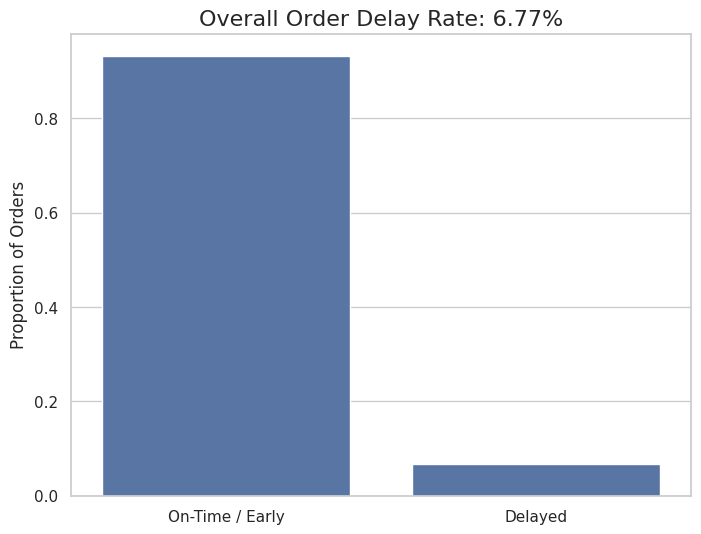

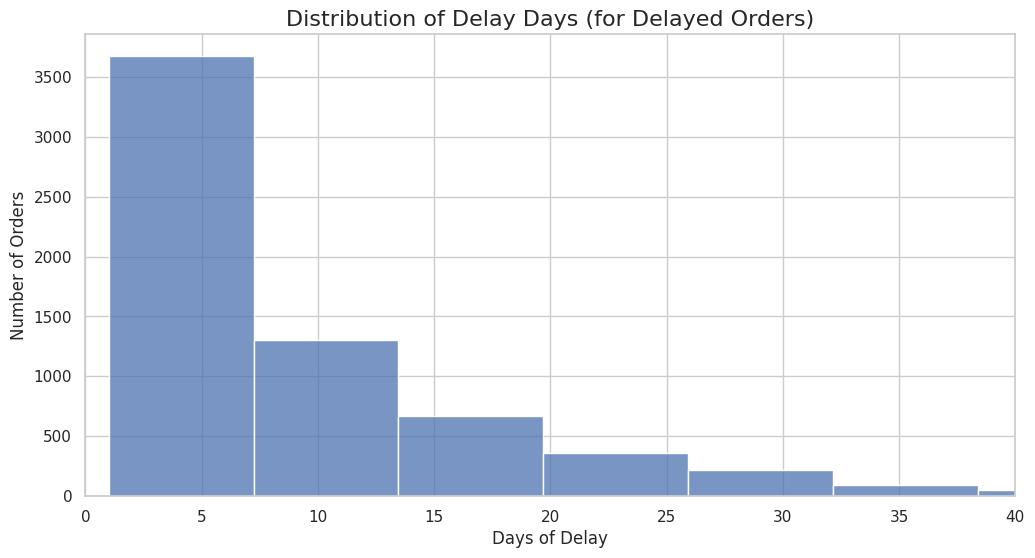

count    6533.000000
mean       10.620848
std        14.645964
min         1.000000
25%         3.000000
50%         7.000000
75%        13.000000
max       188.000000
Name: delivery_delay_days, dtype: float64


In [20]:
# 1. Overall Delay Rate
plt.figure(figsize=(8, 6))
delay_rate = df_master['delayed_flag'].mean()
sns.barplot(x=['On-Time / Early', 'Delayed'], y=[1 - delay_rate, delay_rate])
plt.title(f'Overall Order Delay Rate: {delay_rate:.2%}', fontsize=16)
plt.ylabel('Proportion of Orders')
plt.show()

# 2. Distribution of Delivery Delay (for delayed orders)
plt.figure(figsize=(12, 6))
# We'll filter for delayed orders (delay > 0) to see how late they are
delayed_orders = df_master[df_master['delayed_flag'] == 1]
sns.histplot(delayed_orders['delivery_delay_days'], bins=30, kde=False)
plt.title('Distribution of Delay Days (for Delayed Orders)', fontsize=16)
plt.xlabel('Days of Delay')
plt.ylabel('Number of Orders')
# Set x-limit to something reasonable, as some outliers might be 100+ days
plt.xlim(0, 40)
plt.show()

print(delayed_orders['delivery_delay_days'].describe())

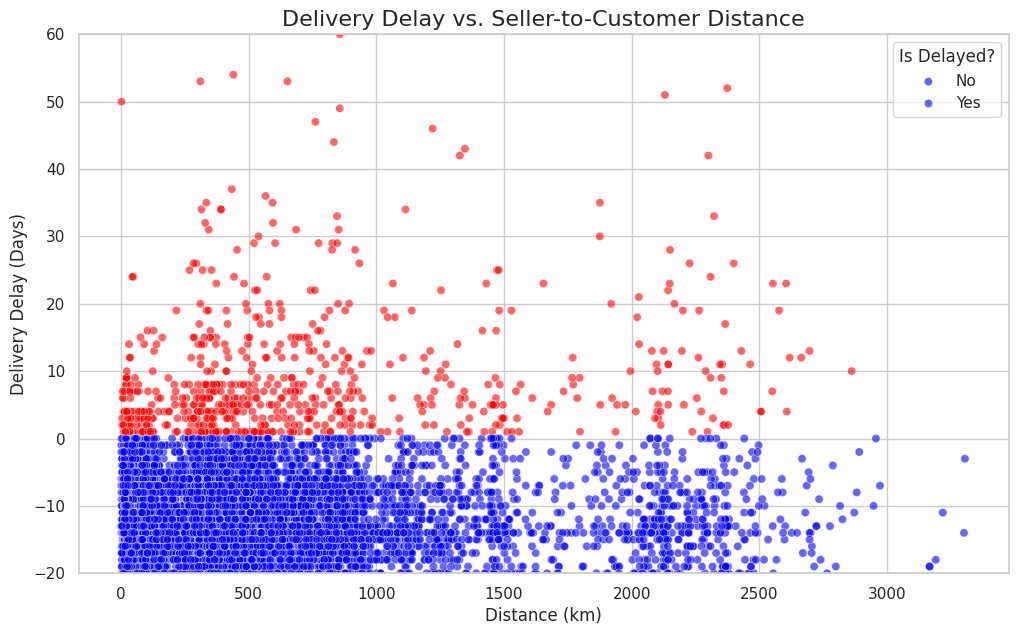

/tmp/ipython-input-42878776.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_by_est_time = df_master.groupby('estimated_time_bin')['delayed_flag'].mean() * 100


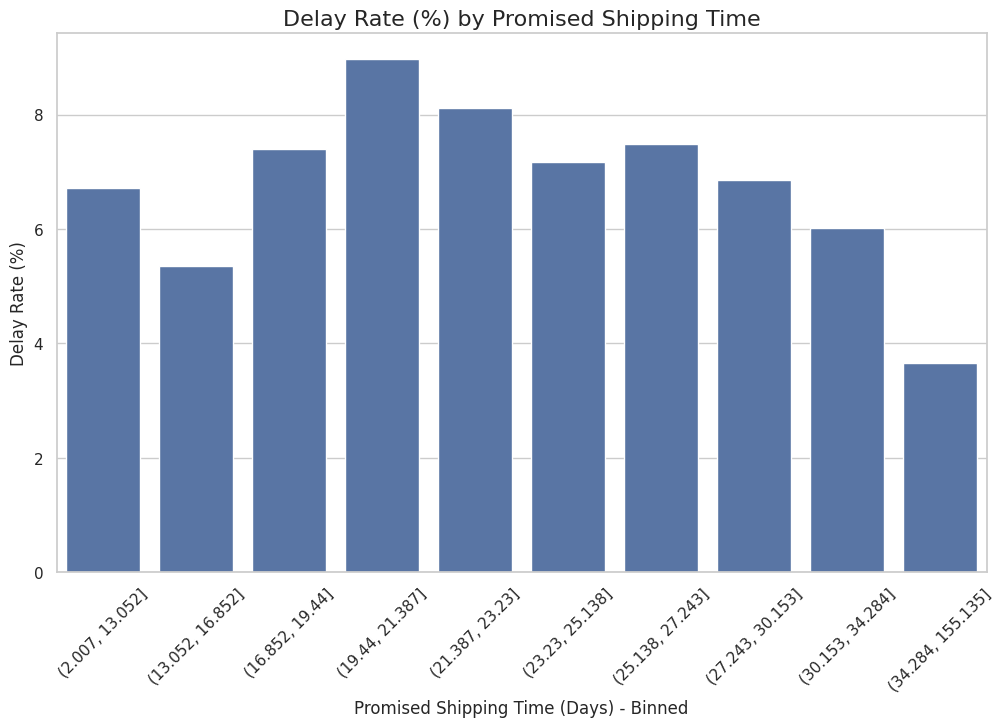

In [21]:
# 1. Is there a correlation between distance and delay?
plt.figure(figsize=(12, 7))
# Create a scatter plot. We'll use a sample to avoid overplotting
df_sample = df_master.sample(10000)
sns.scatterplot(
    data=df_sample,
    x='seller_to_customer_distance_km',
    y='delivery_delay_days',
    hue='delayed_flag',
    alpha=0.6,
    palette={0: 'blue', 1: 'red'}
)
plt.title('Delivery Delay vs. Seller-to-Customer Distance', fontsize=16)
plt.xlabel('Distance (km)')
plt.ylabel('Delivery Delay (Days)')
plt.legend(title='Is Delayed?', labels=['No', 'Yes'])
# We'll set a y-limit to focus on the majority of data
plt.ylim(-20, 60)
plt.show()

# 2. What about the promised (estimated) shipping time?
# Does a longer promise mean a higher chance of delay?
plt.figure(figsize=(12, 7))
# We'll bin the estimated time for a cleaner plot
df_master['estimated_time_bin'] = pd.qcut(df_master['estimated_shipping_time_days'], q=10, duplicates='drop')
delay_by_est_time = df_master.groupby('estimated_time_bin')['delayed_flag'].mean() * 100

sns.barplot(x=delay_by_est_time.index, y=delay_by_est_time.values)
plt.title('Delay Rate (%) by Promised Shipping Time', fontsize=16)
plt.xlabel('Promised Shipping Time (Days) - Binned')
plt.ylabel('Delay Rate (%)')
plt.xticks(rotation=45)
plt.show()


--- Top 10 Sellers by Delay Rate (min 20 orders) ---


,seller_id,total_orders,delay_rate,avg_delay_days
2002,ad781527c93d00d89a11eecd9dcad7c1,35,0.342857,-8.171429
1536,821fb029fc6e495ca4f08a35d51e53a5,24,0.333333,-4.333333
2756,ede0c03645598cdfc63ca8237acbe73d,43,0.325581,-4.116279
994,54965bbe3e4f07ae045b90b0b8541f52,72,0.305556,-3.333333
2863,f76a3b1349b6df1ee875d1f3fa4340f0,23,0.304348,-4.260870
56,054694fa03fe82cec4b7551487331d74,20,0.300000,-0.900000
474,2a1348e9addc1af5aaa619b1a3679d6b,48,0.270833,0.979167
1549,835f0f7810c76831d6c7d24c7a646d4d,41,0.268293,-5.536585
2202,beadbee30901a7f61d031b6b686095ad,63,0.238095,-9.285714
909,4e5725ba188db8252977a4f0227bd462,21,0.238095,-1.952381


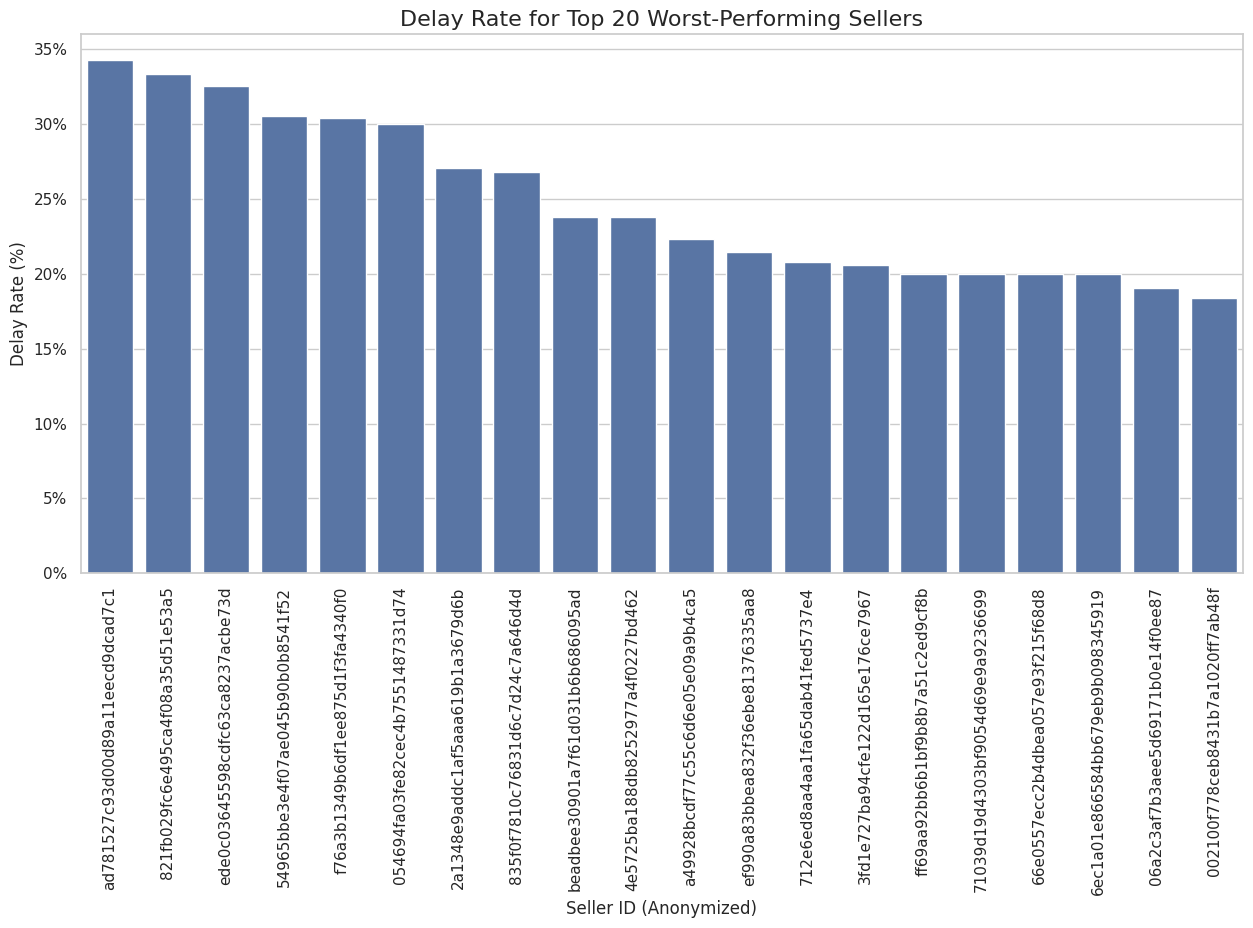

In [22]:
# 1. Analyze performance by seller
# We'll re-calculate stats from our 'df_master' to ensure consistency
seller_analysis = df_master.groupby('seller_id').agg(
    total_orders=('order_id', 'count'),
    delay_rate=('delayed_flag', 'mean'),
    avg_delay_days=('delivery_delay_days', 'mean')
).reset_index()

# 2. Filter out sellers with a small number of orders (e.g., < 20)
# Their delay rates are not statistically significant
significant_sellers = seller_analysis[seller_analysis['total_orders'] >= 20].copy()

# 3. Sort by the highest delay rate
significant_sellers = significant_sellers.sort_values(by='delay_rate', ascending=False)

# 4. Show the Top 10 Worst-Performing Sellers (by Delay Rate)
print("\n--- Top 10 Sellers by Delay Rate (min 20 orders) ---")
display(significant_sellers.head(10))

# 5. Plot the delay rate of the top 20 worst sellers
plt.figure(figsize=(15, 7))
top_20_worst_sellers = significant_sellers.head(20)
sns.barplot(
    data=top_20_worst_sellers,
    x='seller_id',
    y='delay_rate'
)
plt.title('Delay Rate for Top 20 Worst-Performing Sellers', fontsize=16)
plt.ylabel('Delay Rate (%)')
plt.xlabel('Seller ID (Anonymized)')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.show()


--- Top 10 Product Categories by Delay Rate (min 100 orders) ---


,primary_category,total_orders,delay_rate
4,audio,344,0.119186
47,home_confort,370,0.094595
33,fashion_underwear_beach,117,0.094017
10,books_technical,255,0.082353
6,baby,2763,0.081795
57,office_furniture,1246,0.081059
12,christmas_supplies,125,0.080000
26,electronics,2507,0.076586
40,furniture_living_room,409,0.075795
56,musical_instruments,607,0.075783


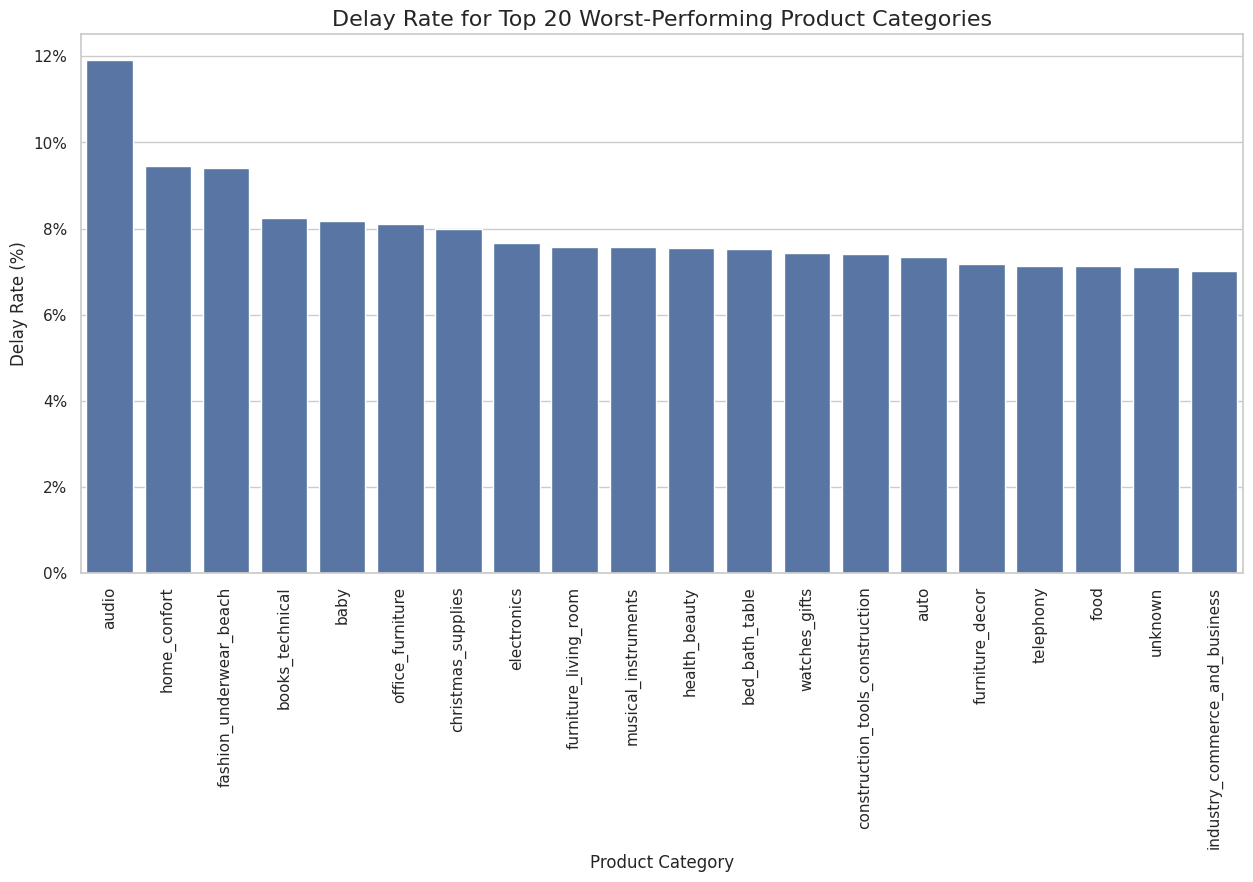

In [23]:
# 1. Analyze performance by product category
category_analysis = df_master.groupby('primary_category').agg(
    total_orders=('order_id', 'count'),
    delay_rate=('delayed_flag', 'mean')
).reset_index()

# 2. Filter out very small categories (e.g., < 100 orders)
significant_categories = category_analysis[category_analysis['total_orders'] >= 100].copy()

# 3. Sort by the highest delay rate
significant_categories = significant_categories.sort_values(by='delay_rate', ascending=False)

# 4. Show the Top 10 Worst-Performing Categories
print("\n--- Top 10 Product Categories by Delay Rate (min 100 orders) ---")
display(significant_categories.head(10))

# 5. Plot the delay rate of the top 20 worst categories
plt.figure(figsize=(15, 7))
top_20_worst_categories = significant_categories.head(20)
sns.barplot(
    data=top_20_worst_categories,
    x='primary_category',
    y='delay_rate'
)
plt.title('Delay Rate for Top 20 Worst-Performing Product Categories', fontsize=16)
plt.ylabel('Delay Rate (%)')
plt.xlabel('Product Category')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.show()